In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# %reload_ext autoreload

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import skimage.io as io

import filters
import homography
import rectification
import utils
import mops

# Detect Corners

In [ ]:
im1 = utils.read_img("data/plush1.jpg")
im2 = utils.read_img("data/plush2.jpg")

In [ ]:
strength1, corners1 = mops.detect_corners(im1)
print(len(corners1))
utils.plot_corners(im1, corners1)
plt.imshow(strength1)

In [ ]:
strength2, corners2 = mops.detect_corners(im2)
print(len(corners2))
utils.plot_corners(im2, corners2)
plt.imshow(strength2)

In [ ]:
corners1[0]

In [1]:
mask.shape

NameError: name 'mask' is not defined

In [2]:
mops.anms(corners1, strength1)

NameError: name 'mops' is not defined

In [3]:
mask.any()

NameError: name 'mask' is not defined

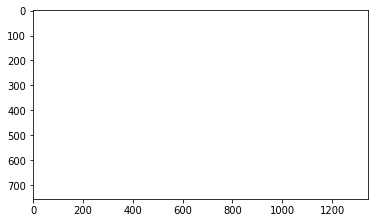

In [25]:
plt.imshow(mask)

# Do Adaptive Non-Maximal Suppression

In [ ]:
detected = corners1
strengths = strength1
keep = set()
NUM_CORNERS = 500 # want to keep the best 500 corners
while len(keep) < NUM_CORNERS:
    strongest_corner = np.argmax(strengths)
    keep.add(strongest_corner)

# Match Features